In [1]:
#import warnings
#warnings.filterwarnings('ignore')
from transformers import AutoTokenizer, AutoModelForCausalLM, AdamW
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from tqdm import tqdm
import matplotlib.pyplot as plt

# Hyperparameters

In [2]:
# Add special tokens
token_name = "[PAWN_nameDef]"
token_possessive ="[PAWN_possessive]"
token_pronoun ="[PAWN_pronoun]"

# Fine-tuning parameters
epochs = 10
learning_rate = 5e-5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device "+str(device))

#the model to load from
model_name_load="gpt2" #get a fresh gpt-2 model from hugging face
#model_name_load="ft1" #load a previously saved model

#the model to save as
model_name_save="ft1" #get a fresh gpt-2 model from hugging face

# data_file_path="raw_data/backstory.csv"
data_file_path="raw_data/backstory.pkl"

using device cuda


# Loading 
## Load Tokenizer and Model

In [3]:
tokenizer = AutoTokenizer.from_pretrained(model_name_load)
#TODO attention mask and the pad token id
#The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
#Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
model = AutoModelForCausalLM.from_pretrained(model_name_load).to(device)

## Dataset Class

In [4]:
# Define a custom dataset class for your sentences
class RimWordDS(Dataset):
    def __init__(self, sentences, tokenizer, max_length=128):
        self.sentences = sentences
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = str(self.sentences[idx])
        inputs = self.tokenizer(sentence, return_tensors="pt", max_length=self.max_length, truncation=True)
        return inputs

## Load Dataset

In [7]:
# load prepocessed data
# Load your DataFrame with sentences
# For example, you can load your data like this:
# df = pd.read_csv(data_file_path,encoding="unicode_escape")
# titles=df["Title"]
# sentences = df["Desc"].tolist()
# print(sentences)
# len_data=len(titles)

import pandas as pd
# data_file_path="backstory.pkl"
df = pd.read_pickle(data_file_path)
titles=df["Title"]
sentences = df["Desc"]
sentences = sentences.tolist()
len_data=len(titles)

for i in range(len_data):
    #print(i,type(sentences[i]),str(sentences[i])) 
    sentences[i]="This is the story of [PAWN_nameDef], a "+titles[i]+": "+sentences[i]
    # TODO attributes

#convert backstroy into proper prompt


sentences_train, sentences_test = train_test_split(sentences, test_size=0.05, random_state=42)

# Create a custom dataset
dataset_train = RimWordDS(sentences_train, tokenizer)
dataset_test = RimWordDS(sentences_test, tokenizer)

# TODO cross validation?
"""
# Split the dataframe into train and test sets, with a test size of 0.03
train, test = train_test_split(df, test_size=0.03, random_state=42)

# Create a cross-validation iterator with 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)


print(sentences[20])
print(sentences[21])
print(sentences[22])"""

df

,Title,Name,Desc,Attribute
0,sewer kid,SewerKid57,[PAWN_nameDef] grew up in the sludge-smeared s...,Cooking+2\t
1,navy scientist,NavyScientist52,"Interstellar warfare is won by technology, so ...",Intellectual+8\t
2,glitterworld empath,GlitterworldEmpath26,[PAWN_nameDef] had an amazing ability to relat...,Social+8\tMedicine+2\t
3,glitterworld surgeon,GlitterworldSurgeon15,[PAWN_nameDef] worked as a surgeon on a world ...,Artistic+5\tMedicine+3\tSocial+1\t
4,novelist,Novelist7,"[PAWN_nameDef] lived on a glitterworld, pennin...",Construction-5\tMining-5\tArtistic+8\t
...,...,...,...,...
757,budding artist,BuddingArtist44,[PAWN_nameDef] had a knack for art. Traders an...,Artistic+5\t
758,bully,Bully70,[PAWN_nameDef] tormented other children for fu...,Melee+2\tShooting+3\t
759,bookworm,Bookworm19,"Rather than socialize with the other children,...",Intellectual+6\tArtistic+2\tSocial-3\t
760,punk,TynanCustomChildhood,[PAWN_nameDef] spent his childhood selling kno...,Intellectual-2\tSocial-2\t


# Model Training
## Train Model

In [8]:
# Add custom tokens to tokenizer
#tokenizer.add_tokens([token_name,token_possessive,token_pronoun])
"""model.resize_token_embeddings(len(tokenizer))

# five fold cross validation
# Loop over the train set and the cross-validation iterator
for train_index, val_index in kf.split(train):
    # Get the train and validation sets for each fold
    train_fold = train.iloc[train_index]
    val_fold = train.iloc[val_index]
    # Training process

train_fold"""

# Set up DataLoader
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=True)
#TODO padding to allow batching
dataloader_train_len=len(dataloader_train)
dataloader_test_len=len(dataloader_test)


# Set up optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate)
#TODO optimizer selection

loss_ot_train=np.zeros(epochs)
loss_ot_test=np.zeros(epochs)

# Fine-tune loop
model.train()
for epoch in range(epochs):
    total_loss_train = 0
    total_loss_test = 0
    
    progress_bar = tqdm(dataloader_train, desc=f"Epoch {epoch + 1}/{epochs}")
    for batch in progress_bar:
        # Move batch to device
        batch = {key: value[0].to(device) for key, value in batch.items()}

        # Forward pass
        outputs = model(**batch, labels=batch["input_ids"])
        loss = outputs.loss

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss_train += loss.item()
        # Update progress bar
        progress_bar.set_postfix({"Loss": total_loss_train / dataloader_train_len})

    for batch_idx, batch in enumerate(dataloader_test, 1):
        # Move batch to device
        batch = {key: value[0].to(device) for key, value in batch.items()}
    
        # Forward pass
        outputs = model(**batch, labels=batch["input_ids"])
        loss = outputs.loss
    
        total_loss_test += loss.item()
    total_loss_test /= dataloader_test_len
    print("Epoch ",epoch,"/10: Test loss=",total_loss_test)
    
    #record loss of the epoch
    loss_ot_train[epoch]=total_loss_train/dataloader_train_len
    loss_ot_test[epoch]=total_loss_test

E:\Anaconda\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/10: 100%|██████████| 723/723 [01:11<00:00, 10.11it/s, Loss=1.62] 


Epoch  0 /10: Test loss= 1.8242541796121843


Epoch 2/10: 100%|██████████| 723/723 [01:13<00:00,  9.80it/s, Loss=1.31] 


Epoch  1 /10: Test loss= 1.8971435198417077


Epoch 3/10: 100%|██████████| 723/723 [01:14<00:00,  9.68it/s, Loss=1.06] 


Epoch  2 /10: Test loss= 2.0195577389154677


Epoch 4/10: 100%|██████████| 723/723 [01:16<00:00,  9.41it/s, Loss=0.832]


Epoch  3 /10: Test loss= 2.185129260405516


Epoch 5/10: 100%|██████████| 723/723 [01:18<00:00,  9.21it/s, Loss=0.662] 


Epoch  4 /10: Test loss= 2.3678681453069053


Epoch 6/10: 100%|██████████| 723/723 [01:19<00:00,  9.13it/s, Loss=0.517] 


Epoch  5 /10: Test loss= 2.510829604589022


Epoch 7/10: 100%|██████████| 723/723 [01:21<00:00,  8.84it/s, Loss=0.418] 


Epoch  6 /10: Test loss= 2.6898797230842786


Epoch 8/10: 100%|██████████| 723/723 [01:24<00:00,  8.56it/s, Loss=0.34]  


Epoch  7 /10: Test loss= 2.717543834295028


Epoch 9/10: 100%|██████████| 723/723 [01:22<00:00,  8.71it/s, Loss=0.29]  


Epoch  8 /10: Test loss= 2.77341178441659


Epoch 10/10: 100%|██████████| 723/723 [01:24<00:00,  8.53it/s, Loss=0.251] 


Epoch  9 /10: Test loss= 2.8852270199702335


## Plot Loss

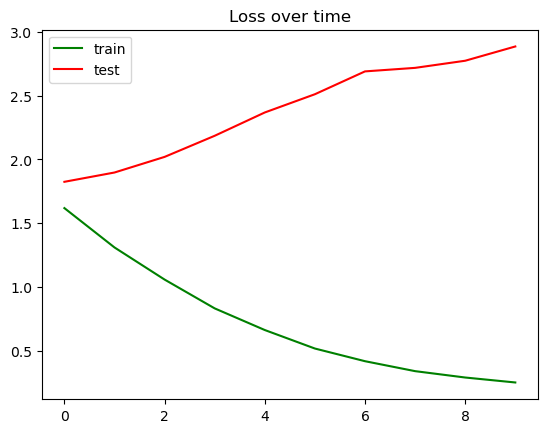

In [11]:
fig, splot = plt.subplots(1)
domain = np.arange(epochs)
splot.plot(domain, loss_ot_train, 'g',label="train")
splot.plot(domain, loss_ot_test, 'r',label="test")
splot.legend()
splot.title.set_text("Loss over time")

## Save the fine-tuned model

In [ ]:
#torch.save(model.state_dict(), 'models/model_v1.pt')

model.save_pretrained(model_name_save)
tokenizer.save_pretrained(model_name_save)

#TODO truncate model to under 100MB? save state dict only?

# Note Area

1. asn3 mingpt
2. asn3 hugging face

# Testing Area
just ignore

In [12]:
sentences_test

['This is the story of [PAWN_nameDef], a renegade engineer: After a daring escape from the prison planet with a small crew of fellow inmates, [PAWN_nameDef] set [PAWN_possessive] gaze on [PAWN_possessive] homeworld.\n\n[PAWN_pronoun] travelled there, recruited more followers, hijacked a space cruiser, and launched into the void.',
 'This is the story of [PAWN_nameDef], a bounty hunter: [PAWN_nameDef] was a bounty hunter on a massive glitterworld. [PAWN_pronoun] worked sensitive assignments for extremely wealthy clients, and was known for quiet execution and total discretion.',
 'This is the story of [PAWN_nameDef], a gardener: [PAWN_nameDef] worked at the mansion of a powerful family, tending the lavish gardens as part of a team of servants.',
 'This is the story of [PAWN_nameDef], a nerd: [PAWN_nameDef] was curious about everything. While other kids played tag in the suburbs of their industrial city, [PAWN_nameDef] read every book [PAWN_pronoun] could find about technology, robots, an

In [ ]:
# Import the necessary modules
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments
import torch
from datasets import load_dataset

# Load the dataset
#dataset = load_dataset("wikitext", "wikitext-2-raw-v1")
dataset = train_dataset

# Preprocess the dataset
def encode(examples):
    input_ids = tokenizer(examples["text"], return_tensors="pt", add_special_tokens=False).input_ids
    labels = input_ids.clone()
    return {"input_ids": input_ids, "labels": labels}

tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModelForCausalLM.from_pretrained("gpt2")
dataset = dataset.map(encode, batched=True, remove_columns=["text"])

# Define the training arguments
training_args = TrainingArguments(
    output_dir="output",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    learning_rate=5e-5,
    logging_steps=100,
    save_steps=500,
    save_total_limit=3,
)

# Create a trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
)

# Train the model
trainer.train()

In [ ]:
import torch
import numpy as np

from nltk.tokenize import sent_tokenize

from pathlib import Path
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
#from mingpt.bpe import BPETokenizer
#from mingpt.utils import set_seed
#set_seed(1234)
"""
Prepare the dataset to train the Language Model (LM)
This implementation splits the sentences and so doesn't create training 
examples that cross sentences.

This code is set so that it uses one of two possible datasets, which were also used in Assignment 1: 
SmallSimpleCorpus.txt or LargerCorpus.txt

Arguments:
            ds_choice: str. "small" or "large". (i.e. selects which of the two datasets)
            split: str. "train" or "test".
            truncation: int. If -1: no truncation on sentences. Otherwise: truncate to this specific length.
"""

class LanguageModelingDataset(Dataset):

    def __init__(self, ds_choice="small", split="train", truncation=-1):

        base_path = "./"
        fn = {"small": "raw_data/backstory.csv", "large": "LargerCorpus.txt"}
        self.ds_choice = ds_choice
        self.truncation = truncation  # int. If -1, then
        text = Path(base_path, fn[ds_choice]).read_text()#encoding='utf-8')
        if ds_choice == "large":
            # Remove the newline char in the middle of sentences
            # The "paragraph splitting" newlines appear to be \n\n -- remove the duplications there
            text = text.replace("\n\n", "$$^^$$").replace("\n", " ").replace("$$^^$$", "\n")
        sentences = sent_tokenize(text)
        for i in range(10):
            print(sentences[i])

        # Train / test split
        train, val = train_test_split(sentences, test_size=0.2, shuffle=False)
        if split == "train":
            raw_data = train
        else:
            raw_data = val

            # Tokenize
        self.tokenizer = tokenizer
        self.data = []  # List of 1-d pytorch tensor
        for sent in raw_data:
            tokenized = self.tokenizer(sent).view(-1)  # pytorch tensor
            if truncation >= 0:
                self.data.append(tokenized[:truncation])
            else:
                self.data.append(tokenized)

        # Count some items
        self.max_sentence_length = np.max([len(d) for d in self.data])

    def __len__(self):
        return len(self.data)

    def get_vocab_size(self):
        """
        We have to set this to the max vocab size (i.e., that decided by the BPE tokenizer), 
        but actually, only a small number of vocab is used, especially for the small text. 
        """
        return 50257

    def __getitem__(self, idx):
        """
        The output should be a tuple x and y, both as pytorch tensors.
        Please refer to the `run()` method in the mingpt/trainer.py script for 
        how the x and y are going to be used.
        """
        x = self.data[idx][:-1]
        y = self.data[idx][1:]
        return (x, y)

    def get_block_size(self):
        """
        block_size is the size at which lines are truncated to ensure they are equal-length.
        """
        return self.max_sentence_length

# Instantiate the Training Dataset
#train_dataset = LanguageModelingDataset(ds_choice="small", split="train")  # use this for the short corpus
train_dataset = LanguageModelingDataset(ds_choice="small", split="train", truncation=512) #use this for long

# Instantiate a Validation Dataset (this is only really needed for the fine-tune task, not the LM task)
#val_dataset = LanguageModelingDataset(ds_choice="small", split="validation")
#val_dataset = LanguageModelingDataset(ds_choice="large", split="validation", truncation=512)

train_dataset

## fix tokenize

In [ ]:
import torch
import numpy as np

from nltk.tokenize import sent_tokenize

from pathlib import Path
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
#from mingpt.bpe import BPETokenizer
#from mingpt.utils import set_seed
#set_seed(1234)
"""
Prepare the dataset to train the Language Model (LM)
This implementation splits the sentences and so doesn't create training 
examples that cross sentences.

This code is set so that it uses one of two possible datasets, which were also used in Assignment 1: 
SmallSimpleCorpus.txt or LargerCorpus.txt

Arguments:
            ds_choice: str. "small" or "large". (i.e. selects which of the two datasets)
            split: str. "train" or "test".
            truncation: int. If -1: no truncation on sentences. Otherwise: truncate to this specific length.
"""

class LanguageModelingDataset(Dataset):

    def __init__(self, ds_choice="small", split="train", truncation=-1):

        base_path = "./"
        fn = {"small": "raw_data/backstory.csv", "large": "LargerCorpus.txt"}
        self.ds_choice = ds_choice
        self.truncation = truncation  # int. If -1, then
        text = Path(base_path, fn[ds_choice]).read_text()#encoding='utf-8')
        if ds_choice == "large":
            # Remove the newline char in the middle of sentences
            # The "paragraph splitting" newlines appear to be \n\n -- remove the duplications there
            text = text.replace("\n\n", "$$^^$$").replace("\n", " ").replace("$$^^$$", "\n")
        sentences = sent_tokenize(text)
        for i in range(10):
            print(sentences[i])

        # Train / test split
        train, val = train_test_split(sentences, test_size=0.2, shuffle=False)
        if split == "train":
            raw_data = train
        else:
            raw_data = val

            # Tokenize
        self.tokenizer = tokenizer
        self.data = []  # List of 1-d pytorch tensor
        
        for sent in raw_data:
            tokenized = self.tokenizer(sent)
            print(sent)
            print(tokenized)
            #tokenized = self.tokenizer(sent).view(-1)  # pytorch tensor
            if truncation >= 0:
                self.data.append(tokenized[:truncation])
            else:
                self.data.append(tokenized)

        # Count some items
        self.max_sentence_length = np.max([len(d) for d in self.data])

    def __len__(self):
        return len(self.data)

    def get_vocab_size(self):
        """
        We have to set this to the max vocab size (i.e., that decided by the BPE tokenizer), 
        but actually, only a small number of vocab is used, especially for the small text. 
        """
        return 50257

    def __getitem__(self, idx):
        """
        The output should be a tuple x and y, both as pytorch tensors.
        Please refer to the `run()` method in the mingpt/trainer.py script for 
        how the x and y are going to be used.
        """
        x = self.data[idx][:-1]
        y = self.data[idx][1:]
        return (x, y)

    def get_block_size(self):
        """
        block_size is the size at which lines are truncated to ensure they are equal-length.
        """
        return self.max_sentence_length

# Instantiate the Training Dataset
#train_dataset = LanguageModelingDataset(ds_choice="small", split="train")  # use this for the short corpus
train_dataset = LanguageModelingDataset(ds_choice="small", split="train", truncation=512) #use this for long

# Instantiate a Validation Dataset (this is only really needed for the fine-tune task, not the LM task)
#val_dataset = LanguageModelingDataset(ds_choice="small", split="validation")
#val_dataset = LanguageModelingDataset(ds_choice="large", split="validation", truncation=512)

train_dataset

## i have huggingface 
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModelForCausalLM.from_pretrained("gpt2")
and a pandas dataframe with a single column where each row represents sentences please write me code that makes it finetune

In [ ]:
prompt ="In rimworld, "
input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)

print(input_ids.get_device())


# sample up to 30 tokens
torch.manual_seed(11)
list_out=[]
#['Today I believe we can finally get rid of discrimination," said Rep. Mark Pocan (D-Wis.).\n\n"Just look at the']
for i in range (1):
    for j in range (8):
        outputs = model.generate(input_ids, do_sample=True, max_length=30, temperature =1+0.05*i,top_p=1,repetition_penalty=1.1)
        list_out.append(outputs)


for i in range (1):
    for j in range (8):
        #print("temperature =",11.6+0.75*i,"top_p=",(j+1)/30)
        print(tokenizer.batch_decode(list_out[i*4+j], skip_special_tokens=True))